https://github.com/sthalles/face-similarity

**위 모델을 serving에 사용하기 위해 savedmodel로 변환하기.**

모델은 잘 모르겠으나 128, 128, 3 의 이미지(-1.0 ~ 1.0)를 32크기로 임베딩하고 L2 거리로 유사도를 측정하는 것 같다.

(구조는 conv-dense로 간단하지만 bias를 사용하지 않거나 regularizer나 he 초기화등 신경을 많이 쓴듯)

원 저자가 코드를 잘 짜놓았고 eager mode로 짜놓아서 테스트하기 편했다.

하지만 tensorflow 1 에서는 keras모델의 model.save 가 아직 savedmodel로 저장하는 기능을 지원하지 않아 

일부 코드를 tf2로 바꾸고 진행함

In [1]:
import tensorflow as tf
import os
from model.densenet import DenseNet
from src.pre_processing import *
import matplotlib.pyplot as plt
from src.contrastive import contrastive_loss
import json
from src.utils import Dotdict
print(tf.__version__)
# tf.enable_eager_execution()

/Users/minhyeoklee/.pyenv/versions/3.6.7/envs/open-tube/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/minhyeoklee/.pyenv/versions/3.6.7/envs/open-tube/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/minhyeoklee/.pyenv/versions/3.6.7/envs/open-tube/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

2.0.0-beta1


In [ ]:
# if running locally, comment these lines
!wget https://www.dropbox.com/s/4tjix8rhyzxpc28/dataset.tar.gz
!wget https://www.dropbox.com/s/zj1v8n5href2mtu/tboard_logs.tar.gz
!tar -xvzf dataset.tar.gz
!tar -xvzf tboard_logs.tar.gz

In [ ]:
# if running locally, comment these lines
!mkdir src
!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/src/contrastive.py
!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/src/cyclical_lr.py
!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/src/pre_processing.py
!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/src/utils.py
!mv contrastive.py ./src/
!mv cyclical_lr.py ./src/
!mv pre_processing.py ./src/
!mv utils.py ./src/

In [ ]:
# if running locally, comment these lines
!mkdir model
!wget https://raw.githubusercontent.com/sthalles/face-similarity/master/model/densenet.py
!mv densenet.py ./model/

In [3]:
# 설정
work_dir = './tboard_logs'
model_id = 31911
test_dataset_path = './dataset/test_v2.tfrecords'

In [4]:
# 모델 불러오기
checkpoint_dir = os.path.join(work_dir, str(model_id))

# load training metadata (setup path if necessary)
with open(checkpoint_dir + '/meta.json', 'r') as fp:
    training_args = Dotdict(json.load(fp))

In [5]:
# tf tfrecord dataset 준비
# 사용되는 전처리는 resize(BILINEAR), 
# tfe = tf.contrib.eager
test_filenames = [test_dataset_path]
test_dataset = tf.data.TFRecordDataset(test_filenames)
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.map(random_resize_and_crop)
test_dataset = test_dataset.map(normalizer)
test_dataset = test_dataset.shuffle(1000)
test_dataset = test_dataset.batch(8)

In [6]:
# 모델 파라미터
args = {"k": training_args.growth_rate,
        "weight_decay": training_args.l2_regularization,
        "num_outputs": training_args.num_outputs,
        "units_per_block": training_args.units_per_block,
        "momentum": training_args.momentum,
        "epsilon": training_args.epsilon,
        "initial_pool": training_args.initial_pool}

# 모델 생성
model = DenseNet(**args)

In [7]:
# 모델 불러오기
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

root = tf.train.Checkpoint(model=model)

try:
    root.restore(tf.train.latest_checkpoint(checkpoint_dir))
    print("Model {} successfully loaded.".format(model_id))
except:
    print("Error loading model: {}".format(FLAGS.model_id))

Model 31911 successfully loaded.


(8, 128, 128, 3)


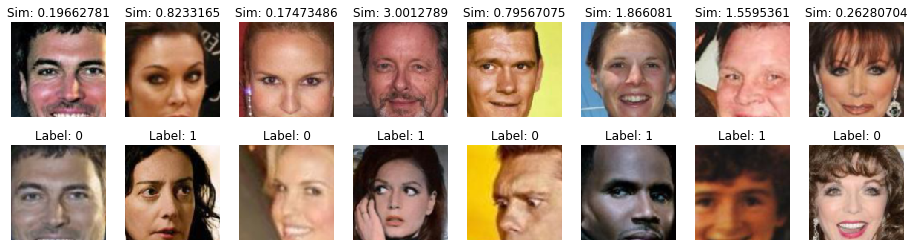

Mean similarity 0.3574601113796234 Mean Std: 0.2550702393054962.
Mean dissimilarity 1.8125531673431396 Mean Std: 0.7839866876602173.


In [8]:
# 모델 테스트.
mean_similarity = []
mean_dissimilarity = []

for (batch, (Xi, Xj, label)) in enumerate(test_dataset):
#     test_dataset_iter = test_dataset.make_one_shot_iterator()
#     Xi, Xj, label = test_dataset_iter.get_next()

    GX1 = model(Xi, training=False)
    GX2 = model(Xj, training=False)
    print(Xi.numpy().shape)

    _, Dw = contrastive_loss(GX1, GX2, label, margin=2.)

    f, axarr = plt.subplots(2, 8, figsize=(16,4))
    f.subplots_adjust(hspace=0.3)

    for i in range(label.shape[0]):

        Si = denormalize(Xi[i]).numpy()
        Sj = denormalize(Xj[i]).numpy()

        if label[i].numpy() == 0:
            mean_similarity.append(Dw[i])
        else:
            mean_dissimilarity.append(Dw[i])

        axarr[0, i].set_title('Sim: ' + str(Dw[i].numpy()))
        axarr[0,i].imshow(np.squeeze(Si))
        axarr[0,i].set_axis_off()

        axarr[1,i].set_title("Label: " + str(label[i].numpy()))
        axarr[1,i].imshow(np.squeeze(Sj))
        axarr[1,i].set_axis_off()

    plt.show()
    break

mean_std_similarity_np = np.std(mean_similarity)
mean_std_dissimilarity_np = np.std(mean_dissimilarity)
mean_similarity_np = np.mean(mean_similarity)
mean_dissimilarity_np = np.mean(mean_dissimilarity)

print("Mean similarity {0} Mean Std: {1}.".format(mean_similarity_np, mean_std_similarity_np))
print("Mean dissimilarity {0} Mean Std: {1}.".format(mean_dissimilarity_np, mean_std_dissimilarity_np))

In [57]:
# model input 레이어 없이 짜놓아서 설정해줄 필요가 있었음
# (fit을 이미 한번 실행했던 모델임에도 왜 필요로 하는지는 모르겠음)
Input = tf.keras.layers.Input

inputs = Input(shape=(128, 128, 3))

model._set_inputs(inputs)
# 내부적으로 fit메소드를 한번 호출하는 듯. (training에 기본 값을 할당안해 놓았을 때 오류가 남)

model.summary()

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dense_block_3 (DenseBlock)   (None, 4, 4, 512)         2412544   
_________________________________________________________________
dense_block (DenseBlock)     (None, 32, 32, 192)       592128    
_________________________________________________________________
dense_block_1 (DenseBlock)   (None, 16, 16, 384)       1505280   
_________________________________________________________________
dense_block_2 (DenseBlock)   (None, 8, 8, 768)         4227072   
_________________________________________________________________
transition_layer (Transition (None, 16, 16, 192)       37

In [14]:
model.save('./dataset/1', save_format='tf')

In [55]:
# signature를 확인하는 방법
!saved_model_cli show --dir ./dataset/1 --tag_set serve --signature_def serving_default
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/tools/saved_model_cli.py

# The given SavedModel SignatureDef contains the following input(s):
#   inputs['input_1'] tensor_info:
#       dtype: DT_FLOAT
#       shape: (-1, 128, 128, 3)
#       name: serving_default_input_1:0
# The given SavedModel SignatureDef contains the following output(s):
#   outputs['output_1'] tensor_info:
#       dtype: DT_FLOAT
#       shape: (-1, 32)
#       name: StatefulPartitionedCall:0
# Method name is: tensorflow/serving/predict


In [54]:
# 모델 사용하는 방법 (2.0 부터 새로 생긴 것 같음)
loaded = tf.saved_model.load('./dataset/1')

In [49]:
print(list(loaded.signatures.keys())) 
# signature 는 항상 dictionary로 저장 되어 있으며 위에 커맨드로 확인한 것과 같은 정보를 가지고 있어
infer = loaded.signatures['serving_default']

print(f'input_signatures: {infer.structured_input_signature[1]}')  # input[0]이 왜 비었었는지는 모르겠어
print(f'output_signatures: {infer.structured_outputs}')

['serving_default']
input_signatures: {'input_1': TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_1')}
output_signatures: {'output_1': TensorSpec(shape=(None, 32), dtype=tf.float32, name='output_1')}


In [51]:
infer(Xi)
# 정말 너무 쉽게 불러와서 사용이 가능.
# 여러 signature로 하나의 savedModel에서 활용도 가능할 것 같음

{'output_1': <tf.Tensor: id=187925, shape=(8, 32), dtype=float32, numpy=
 array([[ 409.36047 , -227.8798  ,   17.01198 , -164.31857 , -137.63487 ,
          192.87668 ,  159.31055 , -242.03687 , -207.73972 ,  -75.49725 ,
          714.12225 , -108.827194,  312.1725  ,  492.2603  , -115.32672 ,
         -490.7234  , -486.449   ,   30.099564,   76.48711 , -494.4576  ,
          599.3808  , -103.53763 ,  -93.74634 ,  160.79312 , -383.2597  ,
          292.93195 ,  382.8724  ,   38.56481 , -197.49011 ,  -50.06308 ,
          -56.304207,  -13.258186],
        [ 409.41382 , -227.93367 ,   16.966322, -165.32872 , -137.67976 ,
          192.81366 ,  159.36674 , -241.9815  , -207.79355 ,  -75.44148 ,
          714.0685  , -108.7715  ,  312.1745  ,  492.3692  , -115.393524,
         -488.22546 , -486.3929  ,   30.153902,   76.533325, -494.52048 ,
          599.33923 , -103.58782 ,  -93.806046,  160.7434  , -383.20273 ,
          292.88058 ,  382.93158 ,   38.612595, -197.55698 ,  -50.041767,
   

In [64]:
x: np.ndarray = Xi.numpy()

x.min(), x.max() # 정규화되어있음, TFRecord에는 0.0~1.0으로 저장했었던듯함